# How do economic and social factors influence national performance in the Olympic Games?

The Olympics have long been a platform where countries not only showcase their athletic prowess but also reflect their socioeconomic standing on the global stage. The distribution of medals often highlights disparities in resources, infrastructure, and societal dynamics. This study investigates how economic factors, such as a country’s GDP or GDP per capita, and social metrics, like the population, influence Olympic performance.

# 0. Import Libraries

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

---

# 1. Import and clean datasets

In [69]:
olympics = pd.read_csv("olympics_dataset.csv")
olympics.head(10)

gdp = pd.read_csv("gdp_per_capita_cleaned.csv")
gdp = gdp.drop(columns=["Unnamed: 65", '0'])

gdp_tot = pd.read_csv("gdp.csv")
gdp_tot = gdp_tot.drop(columns=["Unnamed: 65"])


We need to clean gdp dataset in order to transform the columns (Years from 1960 to 2023) in a new variable called 'Year' for each GDP value of every country.

In [70]:
gdp = gdp.melt(id_vars=["Country Name", "Code"], 
                        var_name="Year", 
                        value_name="GDP_pc")

# Convert the 'Year' column to integer for proper merging
gdp["Year"] = gdp["Year"].astype(int)
gdp['GDP_pc'] = gdp['GDP_pc'].round(1)

gdp.info()
gdp.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16226 entries, 0 to 16225
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  16226 non-null  object 
 1   Code          16226 non-null  object 
 2   Year          16226 non-null  int32  
 3   GDP_pc        12837 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 443.8+ KB


,Country Name,Code,Year,GDP_pc
16216,Virgin Islands,VIR,2020,NaN
16217,Vietnam,VNM,2020,2785.7
16218,Vanuatu,VUT,2020,2870.1
16219,World,WLD,2020,10918.7
16220,Samoa,WSM,2020,4067.8
16221,Kosovo,XKX,2020,4346.6
16222,Yemen,YEM,2020,NaN
16223,South Africa,ZAF,2020,5655.9
16224,Zambia,ZMB,2020,985.1
16225,Zimbabwe,ZWE,2020,1214.5


Same we should do importing the HDI and the Population data from World Bank.

In [71]:
hdi = pd.read_csv("HDI.csv", encoding_errors="ignore")
hdi = hdi.iloc[:, [0] + [1] + list(range(6, 38))]
hdi.head(10)

,iso3,country,1991,1992,1993,1994,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,Afghanistan,0.292,0.299,0.307,0.300,0.318,0.326,0.330,0.329,...,0.475,0.480,0.479,0.483,0.485,0.486,0.492,0.488,0.473,0.462
1,ALB,Albania,0.632,0.616,0.618,0.623,0.632,0.644,0.641,0.656,...,0.793,0.797,0.797,0.795,0.796,0.797,0.800,0.784,0.785,0.789
2,DZA,Algeria,0.596,0.601,0.602,0.603,0.607,0.618,0.626,0.635,...,0.729,0.732,0.736,0.738,0.738,0.740,0.742,0.730,0.740,0.745
3,AND,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.851,0.854,0.856,0.859,0.860,0.863,0.865,0.843,0.855,0.884
4,AGO,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.555,0.565,0.591,0.595,0.597,0.598,0.597,0.594,0.590,0.591
5,ATG,Antigua and Barbuda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.812,0.815,0.818,0.822,0.824,0.828,0.831,0.820,0.819,0.826
6,ARG,Argentina,0.731,0.736,0.740,0.746,0.747,0.752,0.758,0.764,...,0.846,0.847,0.850,0.848,0.853,0.852,0.853,0.841,0.844,0.849
7,ARM,Armenia,0.646,0.611,0.613,0.617,0.623,0.627,0.635,0.647,...,0.757,0.764,0.769,0.773,0.775,0.781,0.789,0.769,0.774,0.786
8,AUS,Australia,0.866,0.868,0.873,0.873,0.882,0.884,0.887,0.891,...,0.929,0.931,0.933,0.936,0.937,0.941,0.941,0.948,0.949,0.946
9,AUT,Austria,0.826,0.832,0.836,0.841,0.847,0.852,0.856,0.861,...,0.907,0.911,0.910,0.913,0.914,0.917,0.920,0.916,0.920,0.926


In [72]:
hdi = hdi.melt(id_vars=["iso3", 'country'], 
                        var_name="Year", 
                        value_name="HDI")

# Convert the 'Year' column to integer for proper merging
hdi["Year"] = hdi["Year"].astype(int)

hdi.info()
hdi.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iso3     6592 non-null   object 
 1   country  6592 non-null   object 
 2   Year     6592 non-null   int32  
 3   HDI      6018 non-null   float64
dtypes: float64(1), int32(1), object(2)
memory usage: 180.4+ KB


,iso3,country,Year,HDI
0,AFG,Afghanistan,1991,0.292
1,ALB,Albania,1991,0.632
2,DZA,Algeria,1991,0.596
3,AND,Andorra,1991,NaN
4,AGO,Angola,1991,NaN
5,ATG,Antigua and Barbuda,1991,NaN
6,ARG,Argentina,1991,0.731
7,ARM,Armenia,1991,0.646
8,AUS,Australia,1991,0.866
9,AUT,Austria,1991,0.826


Let's check if we can merge hdi and gdp DataFames, as their key values have different names.

In [73]:
set(hdi['iso3'])-set(gdp['Code'])

{'ZZA.VHHD',
 'ZZB.HHD',
 'ZZC.MHD',
 'ZZD.LHD',
 'ZZE.AS',
 'ZZF.EAP',
 'ZZG.ECA',
 'ZZH.LAC',
 'ZZI.SA',
 'ZZJ.SSA',
 'ZZK.WORLD'}

Only useless codes (corresponding to aggregates of countries not interesting in my analysis). So we can proceed with the merging.

In [74]:
gdp = gdp.merge(hdi, how = "left", left_on=['Code', 'Year'], right_on=['iso3', 'Year'])

Let's repeat the process with the total GDP table.

In [75]:
gdp_tot = gdp_tot.melt(id_vars=["Country Name", "Code"], 
                        var_name="Year", 
                        value_name="GDP")

# Convert the 'Year' column to integer for proper merging
gdp_tot["Year"] = gdp_tot["Year"].astype(int)
gdp_tot['GDP'] = gdp_tot['GDP'].round(1)

gdp_tot.head()

,Country Name,Code,Year,GDP
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,1.931311e+10
2,Afghanistan,AFG,1960,5.377778e+08
3,Africa Western and Central,AFW,1960,1.040428e+10
4,Angola,AGO,1960,NaN


In [76]:
gdp_tot["Year"] = gdp_tot["Year"].astype(int)
gdp_tot['GDP'] = gdp_tot['GDP'].round(1)

gdp_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16226 entries, 0 to 16225
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  16226 non-null  object 
 1   Code          16226 non-null  object 
 2   Year          16226 non-null  int32  
 3   GDP           12840 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 443.8+ KB


There are 3,389 missing values (NaN) in the GDP data, primarily associated with dictatorial regimes such as North Korea, Turkmenistan, Venezuela and other countries for which reliable data is unavailable.

In [77]:
# we consider only summer olympic games
olympics = olympics[olympics['Season'] != "Winter"]

# Let's filter for only the Olympic years to intercept errors
years = list(range(1896, 2025, 4))
olympics = olympics[olympics["Year"].isin(years)]
olympics.info()


<class 'pandas.core.frame.DataFrame'>
Index: 250832 entries, 0 to 252564
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   player_id  250832 non-null  int64 
 1   Name       250832 non-null  object
 2   Sex        250832 non-null  object
 3   Team       250832 non-null  object
 4   NOC        250832 non-null  object
 5   Year       250832 non-null  int64 
 6   Season     250832 non-null  object
 7   City       250832 non-null  object
 8   Sport      250832 non-null  object
 9   Event      250832 non-null  object
 10  Medal      250832 non-null  object
dtypes: int64(2), object(9)
memory usage: 23.0+ MB


A little bit of cleaning...

In [78]:
def clean_country_name(name):
    # Check if the name ends with any of the patterns '-1', '-2', '-3', '-4', or '-5'
    if any(name.endswith(f'-{i}') for i in range(1, 6)):
        return name[:-2]  # Remove the last two characters (e.g., '-1', '-2', etc.)
    return name

# Apply the function to the column
olympics['Team'] = olympics['Team'].apply(clean_country_name)

olympics.tail(5)

,player_id,Name,Sex,Team,NOC,Year,Season,City,Sport,Event,Medal
252560,4986655,Sefora Ada,F,Equatorial Guinea,GEQ,2024,Summer,Paris,Athletics,Women's 100m,No medal
252561,9460001,Emanuela Liuzzi,F,Italy,ITA,2024,Summer,Paris,Wrestling,Women's Freestyle 50kg,No medal
252562,1972077,Isayah Boers,M,Netherlands,NED,2024,Summer,Paris,Athletics,4 x 400m Relay Mixed,Gold
252563,1899865,Kevin Staut,M,France,FRA,2024,Summer,Paris,Equestrian,Jumping Team,Bronze
252564,1924402,Charlie Carvell,M,Great Britain,GBR,2024,Summer,Paris,Athletics,Men's 4 x 400m Relay,Bronze


Let's import the last dataset about the population.

In [79]:
population = pd.read_csv("population.csv")
population.drop(columns=['Series Name', 'Series Code'], inplace=True)

Same as before, let's transform the columns with the years in a new variable called 'Year'.

In [80]:
population = population.melt(id_vars=["Country Name", "Code"], 
                        var_name="Year", 
                        value_name="Population")

# Convert the 'Year' column to integer for proper merging
population["Year"] = population["Year"].astype(int)
population["Population"] = population["Population"].apply(lambda x: int(x) if pd.notna(x) else x)

population.info()
population.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17024 entries, 0 to 17023
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  17024 non-null  object 
 1   Code          17024 non-null  object 
 2   Year          17024 non-null  int32  
 3   Population    16930 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 465.6+ KB


,Country Name,Code,Year,Population
0,Afghanistan,AFG,1960,8622466.0
1,Albania,ALB,1960,1608800.0
2,Algeria,DZA,1960,11394307.0
3,American Samoa,ASM,1960,20085.0
4,Andorra,AND,1960,9443.0


Let's check if the code of the countries from the population and the gdp datasets are the same and can be used as identifiers.

In [81]:
set(population['Code']) - set(gdp['Code'])

set()

The dataset olympics is the list of all the athletes participating in the modern Olympic Games from 1896 to 2024. As for my analysis I just need the number of medals for each nation in every year I can manipulate the data as following:

- First we need to filter the dataset considering only medalist athletes.
- Then we need to distinguish between individual and team events in order to consider each medal of a team sport only once.

In [82]:
# Filter the data and create a copy to avoid the warning
data_medal = olympics[(olympics['Medal'] != "No medal") & (olympics['Season'] == "Summer")].copy()

data_medal['Category'] = data_medal.duplicated(
    subset=['Event', 'Medal', 'Year', 'Team'], keep=False
).map({True: 'Team', False: 'Individual'})

# Modify the 'Name' column for team events
data_medal.loc[data_medal['Category'] == "Team", 'Name'] = "Team " + data_medal['Team']

# Drop duplicates based on specific columns
data_medal = data_medal.drop_duplicates(
    subset=['Team', 'NOC', 'Year', 'Season', 'City', 'Sport', 'Event', 'Medal', 'Category']
)

display(data_medal[data_medal['Category'] == "Team"].sort_values(['Event', 'Year']))


,player_id,Name,Sex,Team,NOC,Year,Season,City,Sport,Event,Medal,Category
223634,1082,Team Russia,F,Russia,ROC,2020,Summer,Tokyo,Shooting,10m Air Pistol Mixed Team,Silver,Team
228536,5984,Team China,F,China,CHN,2020,Summer,Tokyo,Shooting,10m Air Pistol Mixed Team,Gold,Team
229436,6884,Team Ukraine,F,Ukraine,UKR,2020,Summer,Tokyo,Shooting,10m Air Pistol Mixed Team,Bronze,Team
238002,1538159,Team India,F,India,IND,2024,Summer,Paris,Shooting,10m Air Pistol Mixed Team,Bronze,Team
239920,1564886,Team Turkey,F,Turkey,TUR,2024,Summer,Paris,Shooting,10m Air Pistol Mixed Team,Silver,Team
...,...,...,...,...,...,...,...,...,...,...,...,...
224955,2403,Team South Korea,F,South Korea,KOR,2020,Summer,Tokyo,Fencing,Women's Épée Team,Silver,Team
226404,3852,Team Italy,F,Italy,ITA,2020,Summer,Tokyo,Fencing,Women's Épée Team,Bronze,Team
241901,1894213,Team Poland,F,Poland,POL,2024,Summer,Paris,Fencing,Women's Épée Team,Bronze,Team
244793,1916182,Team France,F,France,FRA,2024,Summer,Paris,Fencing,Women's Épée Team,Silver,Team


- Then we group by the Team and the Year to get the number of medals for each Olympic Game and country.

In [83]:
medal_summary = data_medal.groupby(['Medal', 'NOC', 'Year']).size().reset_index(name='Count').sort_values(["NOC", "Medal"])
medal_summary

,Medal,NOC,Year,Count
0,Bronze,AFG,2008,1
1,Bronze,AFG,2012,1
2107,Silver,AHO,1988,1
2,Bronze,AIN,2024,1
1152,Gold,AIN,2024,1
...,...,...,...,...
2104,Gold,ZIM,1980,1
2105,Gold,ZIM,2004,1
2106,Gold,ZIM,2008,1
3179,Silver,ZIM,2004,1


- Finally to insert in this DataFrame also the Country Name, corresponding to the NOC, we can use the noc.csv file, to create a dictionary which maps every NOC to the corresponding Country Name.

In [84]:
noc = pd.read_csv("./noc.csv")
noc = noc.rename(columns={'region': 'Country Name'})

noc_to_country = noc.set_index('NOC')['Country Name'].to_dict()

noc_to_country

{'AFG': 'Afghanistan',
 'ALB': 'Albania',
 'ALG': 'Algeria',
 'AND': 'Andorra',
 'ANG': 'Angola',
 'ANT': 'Antigua and Barbuda',
 'ARG': 'Argentina',
 'ARM': 'Armenia',
 'ARU': 'Aruba',
 'ASA': 'American Samoa',
 'AUS': 'Australia',
 'AUT': 'Austria',
 'AZE': 'Azerbaijan',
 'BAH': 'Bahamas',
 'BAN': 'Bangladesh',
 'BAR': 'Barbados',
 'BDI': 'Burundi',
 'BEL': 'Belgium',
 'BEN': 'Benin',
 'BER': 'Bermuda',
 'BHU': 'Bhutan',
 'BIH': 'Bosnia and Herzegovina',
 'BIZ': 'Belize',
 'BLR': 'Belarus',
 'BOL': 'Bolivia',
 'BOT': 'Botswana',
 'BRA': 'Brazil',
 'BRN': 'Bahrain',
 'BRU': 'Brunei',
 'BUL': 'Bulgaria',
 'BUR': 'Burkina Faso',
 'CAF': 'Central African Republic',
 'CAM': 'Cambodia',
 'CAN': 'Canada',
 'CAY': 'Cayman Islands',
 'CGO': 'Republic of the Congo',
 'CHA': 'Chad',
 'CHI': 'Chile',
 'CHN': 'China',
 'CIV': 'Ivory Coast',
 'CMR': 'Cameroon',
 'COD': 'Democratic Republic of the Congo',
 'COK': 'Cook Islands',
 'COL': 'Colombia',
 'COM': 'Comoros',
 'CPV': 'Cape Verde',
 'CRC': '

In [85]:
year_team_gender = olympics.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Country Name', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = (year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']).astype(int)

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Country Name','Total_Athletes']]
year_team_contingent[year_team_contingent['Country Name'] == "East Germany"]

,Year,Country Name,Total_Athletes
1482,1968,East Germany,225
1597,1972,East Germany,297
1712,1976,East Germany,267
1800,1980,East Germany,346
2044,1988,East Germany,259


In [86]:
year_team_gender_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             3987 non-null   int64  
 1   Country Name     3987 non-null   object 
 2   Female_Athletes  3987 non-null   float64
 3   Male_Athletes    3987 non-null   float64
 4   Total_Athletes   3987 non-null   int32  
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 140.3+ KB


In [87]:
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# Fill NaN values with 0 only in the 'F' and 'M' columns
year_team_gender_count[('Name', 'F')] = year_team_gender_count[('Name', 'F')].fillna(0).astype(int)
year_team_gender_count[('Name', 'M')] = year_team_gender_count[('Name', 'M')].fillna(0).astype(int)


year_team_gender_count[year_team_gender_count['Year'] == 1972].head(30)

Year                 Team Name     
Sex                                F    M
1567  1972          Afghanistan    0    8
1568  1972              Albania    1    4
1569  1972              Algeria    0    5
1570  1972            Argentina    4   88
1571  1972            Australia   29  139
1572  1972              Austria   14   97
1573  1972              Bahamas    1   19
1574  1972             Barbados    5    8
1575  1972              Belgium    6   82
1576  1972               Belize    0    1
1577  1972                Benin    0    3
1578  1972              Bermuda    0    9
1579  1972              Bolivia    0   11
1580  1972               Brazil    3   77
1581  1972             Bulgaria   24  105
1582  1972         Burkina Faso    0    1
1583  1972             Cambodia    1    8
1584  1972             Cameroon    0   11
1585  1972               Canada   50  157
1586  1972                 Chad    0    4
1587  1972                Chile    2    9
1588  1972       Chinese Taipei    6   15
1589  1972             Colombia    4   55
1590  1972  Congo (Brazzaville)    0    6
1591  1972           Costa Rica    0    3
1592  1972        Cote d'Ivoire    0   11
1593  1972                 Cuba   28  109
1594  1972       Czechoslovakia   36  145
1595  1972              Denmark   12  114
1596  1972   Dominican Republic    0    5

In [88]:
medal_summary['Country Name'] = medal_summary['NOC'].map(noc_to_country)
medal_summary.tail(10)

,Medal,NOC,Year,Count,Country Name
3177,Silver,YUG,1988,4,Yugoslavia
1149,Bronze,ZAM,1984,1,Zambia
1150,Bronze,ZAM,2024,1,Zambia
3178,Silver,ZAM,1996,1,Zambia
1151,Bronze,ZIM,2004,1,Zimbabwe
2104,Gold,ZIM,1980,1,Zimbabwe
2105,Gold,ZIM,2004,1,Zimbabwe
2106,Gold,ZIM,2008,1,Zimbabwe
3179,Silver,ZIM,2004,1,Zimbabwe
3180,Silver,ZIM,2008,3,Zimbabwe


- In the end I can finally create the merged DataFrame where for every Olympic Game I will have the total number of medals, th gold, silvers and bronze and the corresponding gdp_pc and population.

In [89]:
summary_df = (
    medal_summary.groupby(['Year', 'Country Name', 'NOC'])
    .apply(lambda x: pd.Series({
        'total_medals': x['Count'].sum().astype(int),
        'gold_medals': int(x.loc[x['Medal'] == 'Gold', 'Count'].sum()),
        'silver_medals': x.loc[x['Medal'] == 'Silver', 'Count'].sum().astype(int),
        'bronze_medals': x.loc[x['Medal'] == 'Bronze', 'Count'].sum().astype(int),
    }))
    .reset_index()
)

summary_df['gold_medals'] = summary_df['gold_medals'].astype(int)
summary_df['silver_medals'] = summary_df['silver_medals'].astype(int)
summary_df['bronze_medals'] = summary_df['bronze_medals'].astype(int)
summary_df['total_medals'] = summary_df['total_medals'].astype(int)

summary_df.tail(15)

,Year,Country Name,NOC,total_medals,gold_medals,silver_medals,bronze_medals
1419,2024,Slovenia,SLO,3,2,1,0
1420,2024,South Africa,RSA,6,1,3,2
1421,2024,South Korea,KOR,32,13,9,10
1422,2024,Spain,ESP,18,5,4,9
1423,2024,Sweden,SWE,11,4,4,3
1424,2024,Switzerland,SUI,8,1,2,5
1425,2024,Tajikistan,TJK,3,0,0,3
1426,2024,Thailand,THA,6,1,3,2
1427,2024,Tunisia,TUN,3,1,1,1
1428,2024,Turkey,TUR,8,0,3,5


Finally let's create the merged DataFrame on the Country Name, after making sure that it is the same in all the 3 starting datasets.

In [90]:
app = gdp.merge(population, how = 'left', on = ['Code', 'Year']).drop(columns=['Country Name_y', 'Country Name_x'])
app = app.merge(gdp_tot, on = ['Code', 'Year'])
app = app.merge(year_team_contingent, how = "right", on = ['Country Name', 'Year'])
app.rename(columns={'Country Name_x': 'Country Name'}, inplace=True)

In [91]:
df = summary_df.merge(app, how = "left", on = ['Country Name', 'Year'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1434 entries, 0 to 1433
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            1434 non-null   int64  
 1   Country Name    1434 non-null   object 
 2   NOC             1434 non-null   object 
 3   total_medals    1434 non-null   int32  
 4   gold_medals     1434 non-null   int32  
 5   silver_medals   1434 non-null   int32  
 6   bronze_medals   1434 non-null   int32  
 7   Code            937 non-null    object 
 8   GDP_pc          867 non-null    float64
 9   iso3            618 non-null    object 
 10  country         618 non-null    object 
 11  HDI             600 non-null    float64
 12  Population      937 non-null    float64
 13  GDP             867 non-null    float64
 14  Total_Athletes  1425 non-null   float64
dtypes: float64(5), int32(4), int64(1), object(5)
memory usage: 145.8+ KB


Now let's add the final variable regarding the hosting nation. This will be a dummy variable corresponding to 1 if the nation has hosted the Olympic Games in the specific year, 0 otherwise.

In [92]:
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Roma' : 'Italy',
                  'Munich': 'Germany',
                  'Melbourne': 'Australia',
                  'Montreal': 'Canada',
                  'Moskva': 'Russia',
                  'Helsinki': 'Finland',
                  'Stockholm': 'Sweden',
                  'Los Angeles': 'United States',
                  'St. Louis': 'United States',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Berlin': 'Germany',
                  'Atlanta': 'United States',
                  'Sydney': 'Australia',
                  'Paris': 'France',
                  'Antwerpen': 'Belgium',
                  'Amsterdam': 'Netherlands',
                  'Athina': 'Greece',
                  'Beijing': 'China',
                  'London': 'Great Britain',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics['Country_Host'] = olympics['City'].map(city_to_country)
olympics.loc[olympics['Year'] == 1956, 'Country_Host'] = 'Australia'
host = olympics.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')
host

,Year,Country_Host
2676,1896,Greece
3,1900,France
629,1904,United States
979,1908,Great Britain
10,1912,Sweden
2,1920,Belgium
14,1924,France
71,1928,Netherlands
4,1932,United States
44,1936,Germany


In [93]:
df = df.merge(host, how = "left", on = "Year")

Let's create the new column.

In [94]:
row_mask = (df['Country_Host'] == df['Country Name']).astype(int)
df['Country_Host'] = row_mask

In order to compare indexes from different years I've decided to standardize the variables, this is because the value of the GDP, Number of Medals, Population and Number of Athletes could vary a lot during the years. Moreover those variables usually tend to increase through the time, so to make comparisons I need to standardize.

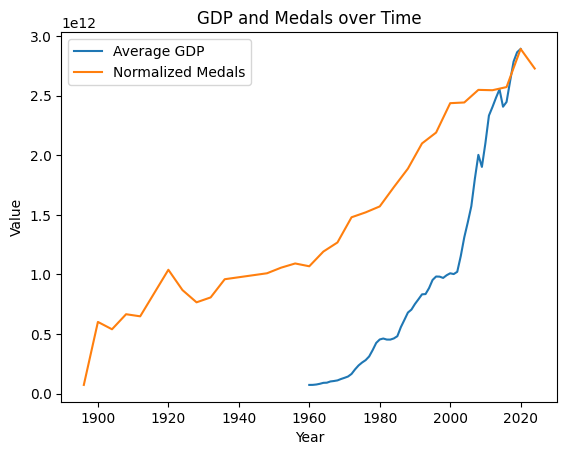

In [96]:
gg = gdp_tot[['GDP', 'Year']].groupby('Year').mean()
mm = df[['total_medals', 'Year']].groupby('Year').sum()

plt.plot(gg, label='Average GDP')
nn = (mm - np.min(mm)) / (np.max(mm) - np.min(mm)) * (np.max(gg) - np.min(gg)) + np.min(gg)
plt.plot(nn, label='Normalized Medals')

plt.legend() 
plt.xlabel('Year')  
plt.ylabel('Value')  
plt.title('GDP and Medals over Time')  
plt.show()  


Let's normalize...

In [29]:
df["gdp_pc_norm"] = df.groupby("Year")["GDP_pc"].transform(lambda x: (x - x.mean()) / x.std())
df["gdp_norm"] = df.groupby("Year")["GDP"].transform(lambda x: (x - x.mean()) / x.std())
df["medals_norm"] = df.groupby("Year")["total_medals"].transform(lambda x: (x - x.mean()) / x.std())
df["Population_perc"] = df.groupby("Year")["Population"].transform(lambda x: (x / x.sum())*100)

For some analysis I will only consider the Olympic Games from 1990 to 2021, because these are the the only years we have info about the HDI and the GDP (at least for some countries). For the analysis that don't consider these indexes I will consider all the Modern Olympic Summer Games from Athens 1896 to Paris 2024.

In [30]:
df_reduced = df[(df['Year'] > 1959) & (df['Year'] != 2024)]

df_reduced.head(5)

,Year,Country Name,NOC,total_medals,gold_medals,silver_medals,bronze_medals,Code,GDP_pc,iso3,country,HDI,Population,GDP,Total_Athletes,Country_Host,gdp_pc_norm,gdp_norm,medals_norm,Population_perc
349,1960,Argentina,ARG,2,0,1,1,ARG,NaN,NaN,NaN,NaN,20349744.0,NaN,84.0,0,NaN,NaN,-0.438318,1.415646
350,1960,Australia,AUS,22,8,8,6,AUS,1810.6,NaN,NaN,NaN,10276477.0,1.860679e+10,179.0,0,1.034821,-0.170816,0.572281,0.714891
351,1960,Austria,AUT,2,1,1,0,AUT,935.5,NaN,NaN,NaN,7047539.0,6.592694e+09,96.0,0,-0.075799,-0.289489,-0.438318,0.490268
352,1960,Belgium,BEL,4,0,2,2,BEL,1273.7,NaN,NaN,NaN,9153489.0,1.165872e+10,98.0,0,0.353423,-0.239448,-0.337258,0.636770
353,1960,Brazil,BRA,2,0,0,2,BRA,NaN,NaN,NaN,NaN,73092515.0,NaN,68.0,0,NaN,NaN,-0.438318,5.084738


In [31]:
df[df['Year'] == 2020].sort_values(by = 'total_medals', ascending=False).head(6)

,Year,Country Name,NOC,total_medals,gold_medals,silver_medals,bronze_medals,Code,GDP_pc,iso3,country,HDI,Population,GDP,Total_Athletes,Country_Host,gdp_pc_norm,gdp_norm,medals_norm,Population_perc
1341,2020,United States,USA,113,39,41,33,USA,63593.4,USA,United States,0.923,3.315269e+08,2.095303e+13,633.0,0,1.911975,7.178720,5.310635,5.356665
1266,2020,China,CHN,88,38,32,18,CHN,10434.8,CHN,China,0.781,1.411100e+09,1.472273e+13,419.0,0,-0.455902,4.947066,4.001140,22.799929
1323,2020,Russia,ROC,71,20,28,23,RUS,10126.7,RUS,Russian Federation,0.826,1.452451e+08,1.483498e+12,341.0,0,-0.469626,0.204857,3.110684,2.346807
1284,2020,Great Britain,GBR,65,22,21,22,GBR,41059.2,GBR,United Kingdom,0.920,6.708123e+07,2.759804e+12,392.0,0,0.908220,0.662022,2.796405,1.083869
1297,2020,Japan,JPN,58,27,14,17,JPN,40193.3,JPN,Japan,0.917,1.262610e+08,5.057759e+12,613.0,1,0.869650,1.485135,2.429746,2.040069
1253,2020,Australia,AUS,46,17,7,22,AUS,51692.8,AUS,Australia,0.948,2.564925e+07,1.327836e+12,489.0,0,1.381879,0.149100,1.801189,0.414429


---

# 2 Exploratory Data Analysis

### 2.1 All time medal table

In [32]:
medals_by_country = (
    summary_df.groupby(['Country Name'])[['gold_medals', 'silver_medals', 'bronze_medals']]
    .sum()
    .sort_values(by='gold_medals', ascending=False)
    .head(10)
)

medals_by_country['total_medals'] = medals_by_country.sum(axis=1)

medals_by_country

,gold_medals,silver_medals,bronze_medals,total_medals
Country Name,,,,
United States,1101,880,775,2756
Soviet Union,394,317,294,1005
Great Britain,305,348,345,998
China,305,221,195,721
Germany,252,278,303,833
France,245,284,304,833
Italy,234,207,230,671
Japan,189,160,191,540
Hungary,188,163,181,532


### 2.1.1 Graph of all-time medal table (Top 10)

<Figure size 1400x1000 with 0 Axes>

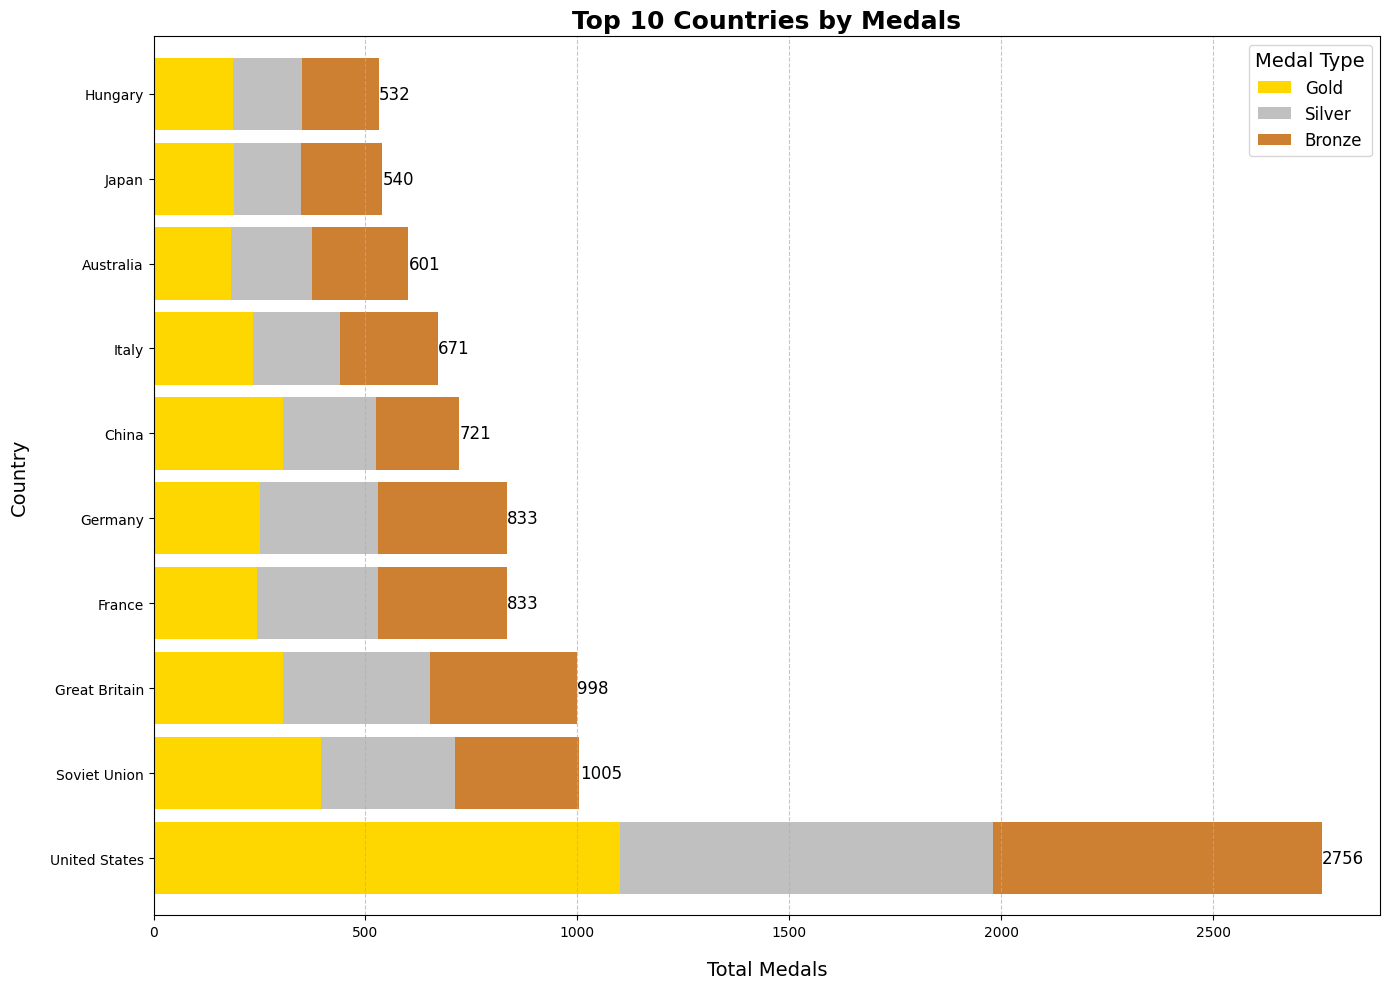

In [33]:
medals_by_country_sorted = medals_by_country.sort_values(by='total_medals', ascending=True)

medals_by_country_sorted = medals_by_country_sorted.drop(columns='total_medals')

plt.figure(figsize=(14, 10))  

ax = medals_by_country_sorted.plot(
    kind='barh',
    stacked=True,
    color=['gold', 'silver', '#cd7f32'], 
    figsize=(14, 10),
    width=0.85
)

plt.title('Top 10 Countries by Medals', fontsize=18, fontweight='bold') 
plt.xlabel('Total Medals', fontsize=14, labelpad=15)  
plt.ylabel('Country', fontsize=14, labelpad=15)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.legend(title='Medal Type', loc='upper right', fontsize=12, title_fontsize=14, labels=['Gold', 'Silver', 'Bronze'])

# Inverting the y-axis to have the top countries on top
plt.gca().invert_yaxis()

for i, country in enumerate(medals_by_country_sorted.index):
    gold = medals_by_country_sorted.loc[country, 'gold_medals']
    silver = medals_by_country_sorted.loc[country, 'silver_medals']
    bronze = medals_by_country_sorted.loc[country, 'bronze_medals']
    total = gold + silver + bronze
    ax.text(total + 0.5, i, f'{total}', va='center', fontsize=12, color='black')  # Display total medals

# Tightening layout to avoid overlapping
plt.tight_layout()

plt.show()


## 2.2 Analysis of the correlation between variables.

Now we can start to analyze if exists a correlation between the medals obtained, the gdp and the population of a country.

### 2.2.1 Correlation Matrix

Correlation Matrix between the standardized variables.

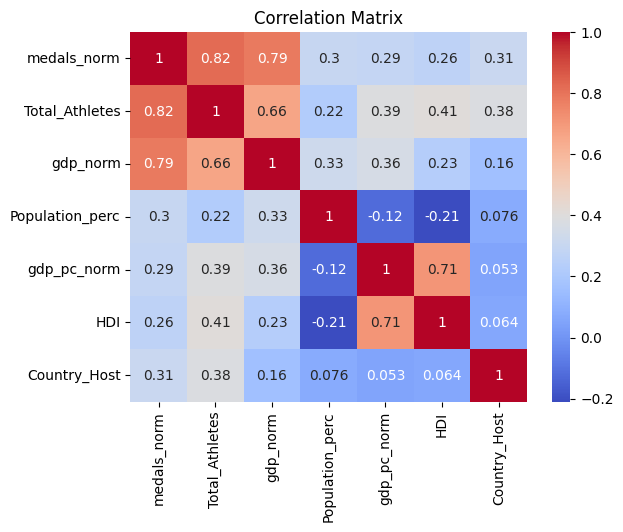

In [34]:
# Correlation heatmap
corr = df[["medals_norm", "Total_Athletes", "gdp_norm", "Population_perc", "gdp_pc_norm", 'HDI', 'Country_Host']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Correlation Matrix between the non-standardized variables.

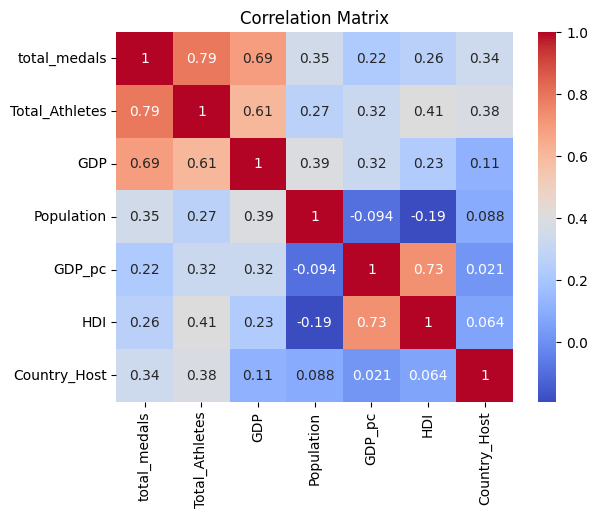

In [35]:
# Correlation heatmap
corr = df[["total_medals", "Total_Athletes", "GDP", "Population", "GDP_pc", 'HDI', 'Country_Host']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Similar, but anyway some differences, especially in the GDP values, which is the most influenced by the Year.

Let's move on to analysis some singular variables correlation to understand better the relationship.

### 2.2.2 Does hosting the Games enhance performances?

findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.
findfont: Font family 'sansserif' not found.


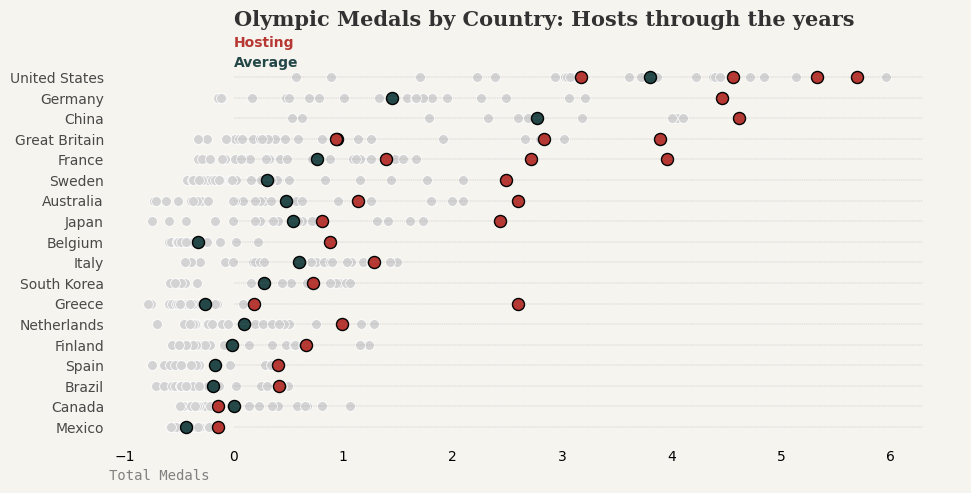

In [36]:
# Background color
background_color = '#F5F4EF'

fig, ax = plt.subplots(1, 1, figsize=(11, 5), facecolor=background_color)

# Top 20 paesi per medaglie, escludendo certi paesi
top_list_ = (
    df[df['Country_Host'] == 1].groupby('Country Name')['total_medals']
    .mean()
    .sort_values(ascending=False)
    .reset_index()[:20]
    .sort_values(by='total_medals', ascending=True)
)
top_list_ = top_list_[~top_list_['Country Name'].isin(['West Germany', 'Unified Team', 'Soviet Union', 'East Germany'])]

top_list_['plot'] = range(1, len(top_list_) + 1)

for _, row in top_list_.iterrows():
    country = row['Country Name']
    plot = row['plot']
    mean = df[df['Country Name'] == country].groupby('Country Name')['medals_norm'].mean()

    # Punteggi storici
    sns.scatterplot(
        data=df[df['Country Name'] == country],
        y=plot,
        x='medals_norm',
        color='lightgray',
        s=50,
        ax=ax
    )

    # Punteggio medio
    sns.scatterplot(
        x=mean,
        y=plot,
        color='#244747',
        edgecolor='black',
        linewidth=1,
        s=75,
        ax=ax
    )

    # Punteggi dei paesi ospitanti
    sns.scatterplot(
        data=df[(df['Country Name'] == country) & (df['Country_Host'] == 1)],
        y=plot,
        x='medals_norm',
        color='#B73832',
        edgecolor='black',
        linewidth=1,
        s=75,
        ax=ax
    )

ax.set_yticks(top_list_['plot'])
ax.set_yticklabels(
    top_list_['Country Name'],
    fontdict={'horizontalalignment': 'right'},
    alpha=0.7
)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel(
    "Total Medals",
    fontfamily='monospace',
    loc='left',
    color='gray'
)

# Sfondo e griglia
ax.set_facecolor(background_color)
ax.hlines(
    y=top_list_['plot'],
    xmin=0,
    xmax=ax.get_xlim()[1],
    color='gray',
    alpha=0.5,
    linewidth=0.3,
    linestyles='--'
)
ax.set_axisbelow(True)

# Rimozione bordi
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)

# Titoli e annotazioni
ax.text(0, len(top_list_) + 2.5, 'Olympic Medals by Country: Hosts through the years',
        fontsize=15, fontweight='bold', fontfamily='serif', color='#323232')
ax.text(0, len(top_list_) + 1.5, 'Hosting',
        fontsize=10, fontweight='bold', fontfamily='sansserif', color='#B73832')
ax.text(0, len(top_list_) + 0.5, 'Average',
        fontsize=10, fontweight='bold', fontfamily='sansserif', color='#244747')

plt.show()


We can see that the hosting country always reap the benefits of hosting the Olympic Games with a great boost in the medals obtained.

---

### 2.2.3 Correlation between GDP & Population with total medals

In [37]:
df_summary = df.groupby(['Country Name'])[['medals_norm', 'gdp_norm', 'Population_perc']].mean()

C:\Users\ricca\AppData\Local\Temp\ipykernel_20188\3673762939.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


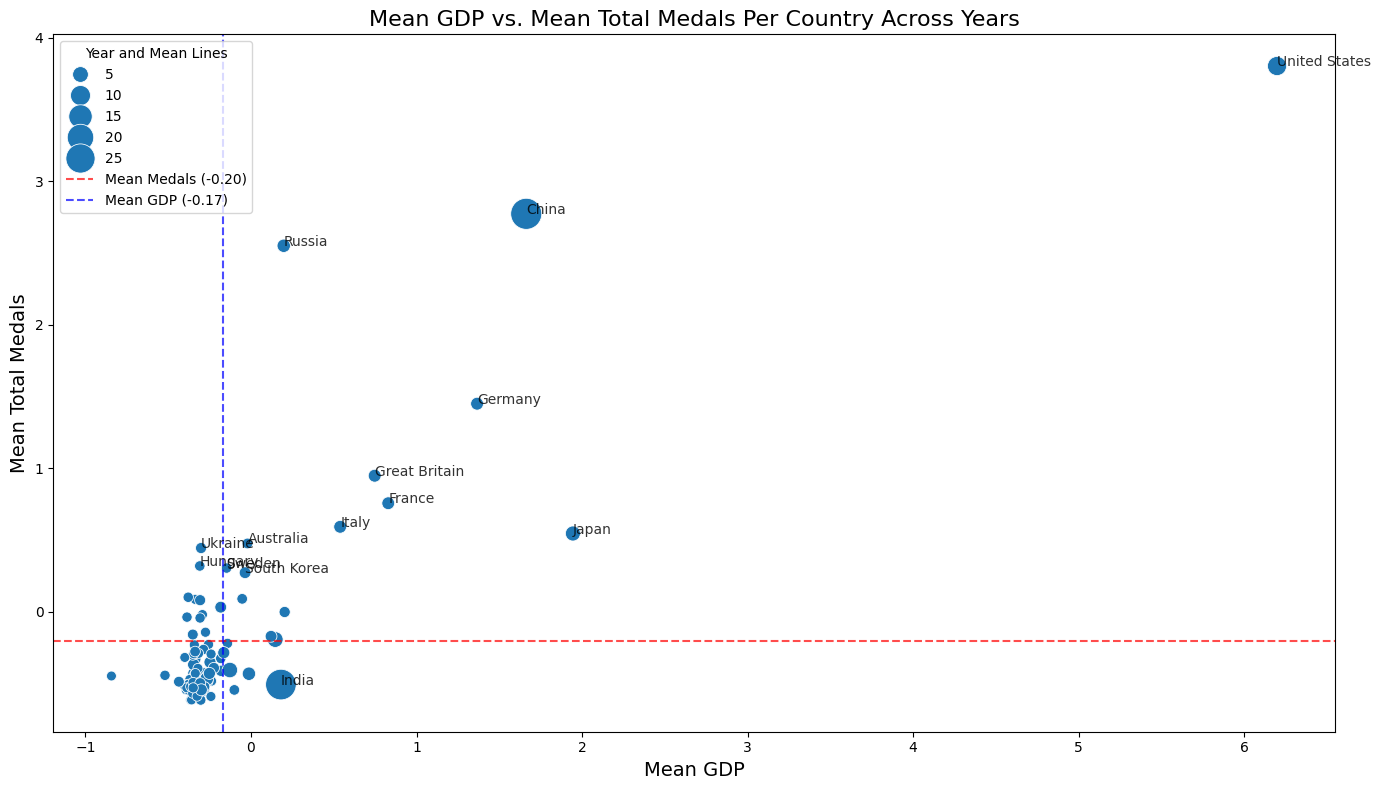

In [38]:
plt.figure(figsize=(14, 8))

sns.scatterplot(
    x="gdp_norm",  # Mean GDP across years for each country
    y="medals_norm",  # Mean medals across years for each country
    size="Population_perc",  # Mean population across years for size
    sizes=(50, 500),
    data=df_summary,
    palette="viridis",
    legend="brief"
)

mean_gdp = df_summary["gdp_norm"].mean()
mean_medals = df_summary["medals_norm"].mean()
plt.axhline(mean_medals, color="red", linestyle="--", label=f"Mean Medals ({mean_medals:.2f})", alpha=0.7)
plt.axvline(mean_gdp, color="blue", linestyle="--", label=f"Mean GDP ({mean_gdp:.2f})", alpha=0.7)

plt.title("Mean GDP vs. Mean Total Medals Per Country Across Years", fontsize=16)
plt.xlabel("Mean GDP", fontsize=14)
plt.ylabel("Mean Total Medals", fontsize=14)

plt.legend(title="Year and Mean Lines", loc="upper left", fontsize=10)

# Select countries for annotations
selected_countries = df_summary[(df_summary['medals_norm'] > 0.2) | (df_summary['Population_perc'] > 15)].index
filtered_df = df_summary.loc[selected_countries]  # Filter for chosen countries

# Add annotations
texts = [
    plt.text(
        row["gdp_norm"],
        row["medals_norm"],
        country,
        fontsize=10,
        alpha=0.8
    )
    for country, row in filtered_df.iterrows()
]



plt.tight_layout()
plt.show()


### 2.2.4 Medal Distribution by sport

Let's create the DataFrame where the medals are divided by sports and countries, so I can create the medal distribution per sport to understand which sports influence most the total number of medals in the Olympic Games.

In [39]:
medals_df = data_medal[['NOC', 'Sport', 'Medal']]

# Create dummy variables for each medal type
medals_df = pd.get_dummies(medals_df, columns=['Medal'], prefix='', prefix_sep='')

# Group by 'NOC' and 'Sport' and sum medal counts
grouped_medals = medals_df.groupby(['NOC', 'Sport']).sum()
grouped_medals['Total_Medals'] = grouped_medals[['Gold', 'Silver', 'Bronze']].sum(axis=1)

# Reset index for better readability
grouped_medals = grouped_medals.reset_index()

grouped_medals = grouped_medals.merge(noc, on = "NOC")

grouped_medals.head()

,NOC,Sport,Bronze,Gold,Silver,Total_Medals,Country Name
0,AFG,Taekwondo,2,0,0,2,Afghanistan
1,AHO,Sailing,0,0,1,1,Netherlands Antilles
2,ALB,Wrestling,2,0,0,2,Albania
3,ALG,Artistic Gymnastics,0,1,0,1,Algeria
4,ALG,Athletics,3,4,3,10,Algeria


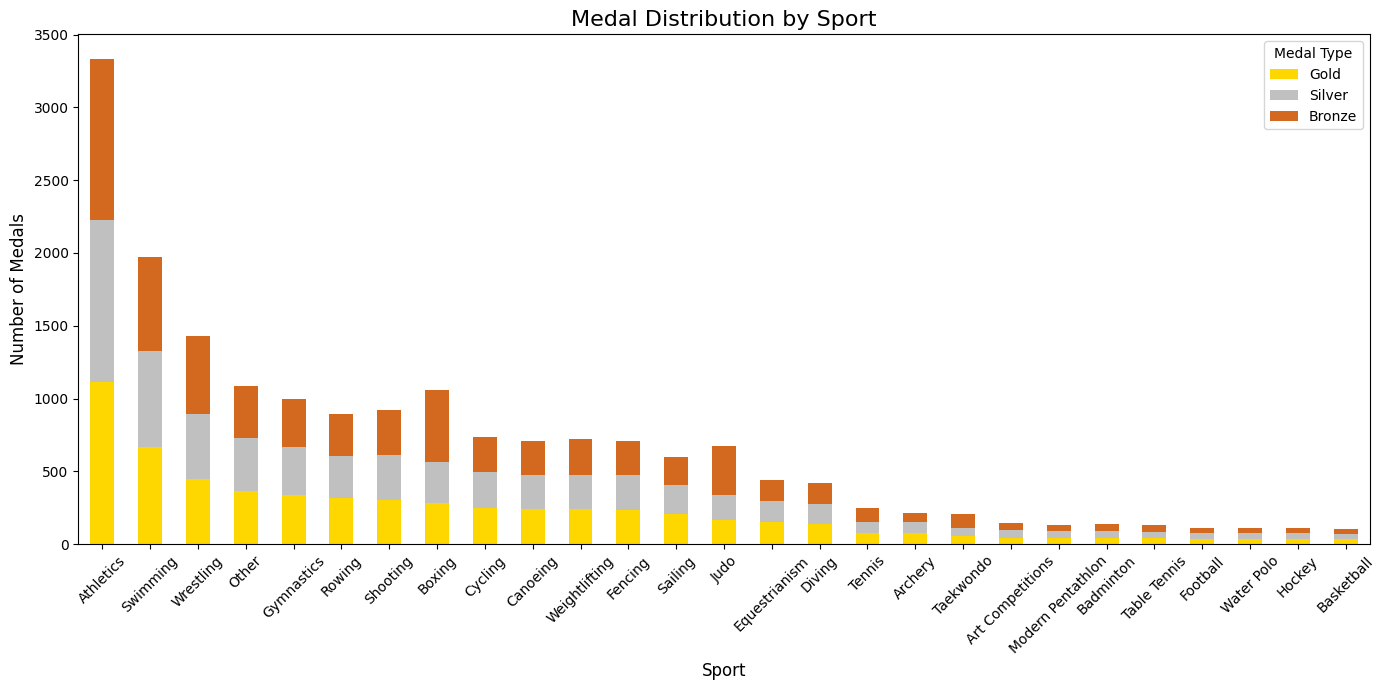

In [40]:
# Add a column for Total Medals
grouped_medals['Total_Medals'] = grouped_medals[['Gold', 'Silver', 'Bronze']].sum(axis=1)

# Separate "Other Competitions"
sport_medals = grouped_medals.groupby('Sport')[['Gold', 'Silver', 'Bronze']].sum()
other_sports = sport_medals[sport_medals['Gold'] + sport_medals['Silver'] + sport_medals['Bronze'] <= 100].sum()
sport_medals = sport_medals[sport_medals['Gold'] + sport_medals['Silver'] + sport_medals['Bronze'] > 100]

# Add "Other Competitions" to the DataFrame
sport_medals.loc['Other'] = other_sports

# Sort by Gold medals
sport_medals = sport_medals.sort_values(by='Gold', ascending=False)

# Custom colors for the medal types
custom_colors = ['gold', 'silver', 'chocolate'] 

sport_medals.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 7), 
    color=custom_colors
)
plt.title('Medal Distribution by Sport', fontsize=16)
plt.xlabel('Sport', fontsize=12)
plt.ylabel('Number of Medals', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Medal Type')
plt.tight_layout()  
plt.show()


### 2.2.5 Which nation excels in which sport?

A heatmap can provide a clear visual representation of a country's medal performance in different sports, showing the proportion of medals won compared to the total possible.

In [41]:
# Group by Sport to get total medals distributed per sport
sport_totals = grouped_medals.groupby('Sport')['Total_Medals'].transform('sum')

# Calculate the percentage of medals won by a country in each sport
grouped_medals['Country_Sport_Percentage'] = (grouped_medals['Total_Medals'] / sport_totals) * 100

grouped_medals.head()


,NOC,Sport,Bronze,Gold,Silver,Total_Medals,Country Name,Country_Sport_Percentage
0,AFG,Taekwondo,2,0,0,2,Afghanistan,0.961538
1,AHO,Sailing,0,0,1,1,Netherlands Antilles,0.168067
2,ALB,Wrestling,2,0,0,2,Albania,0.139665
3,ALG,Artistic Gymnastics,0,1,0,1,Algeria,1.162791
4,ALG,Athletics,3,4,3,10,Algeria,0.299850


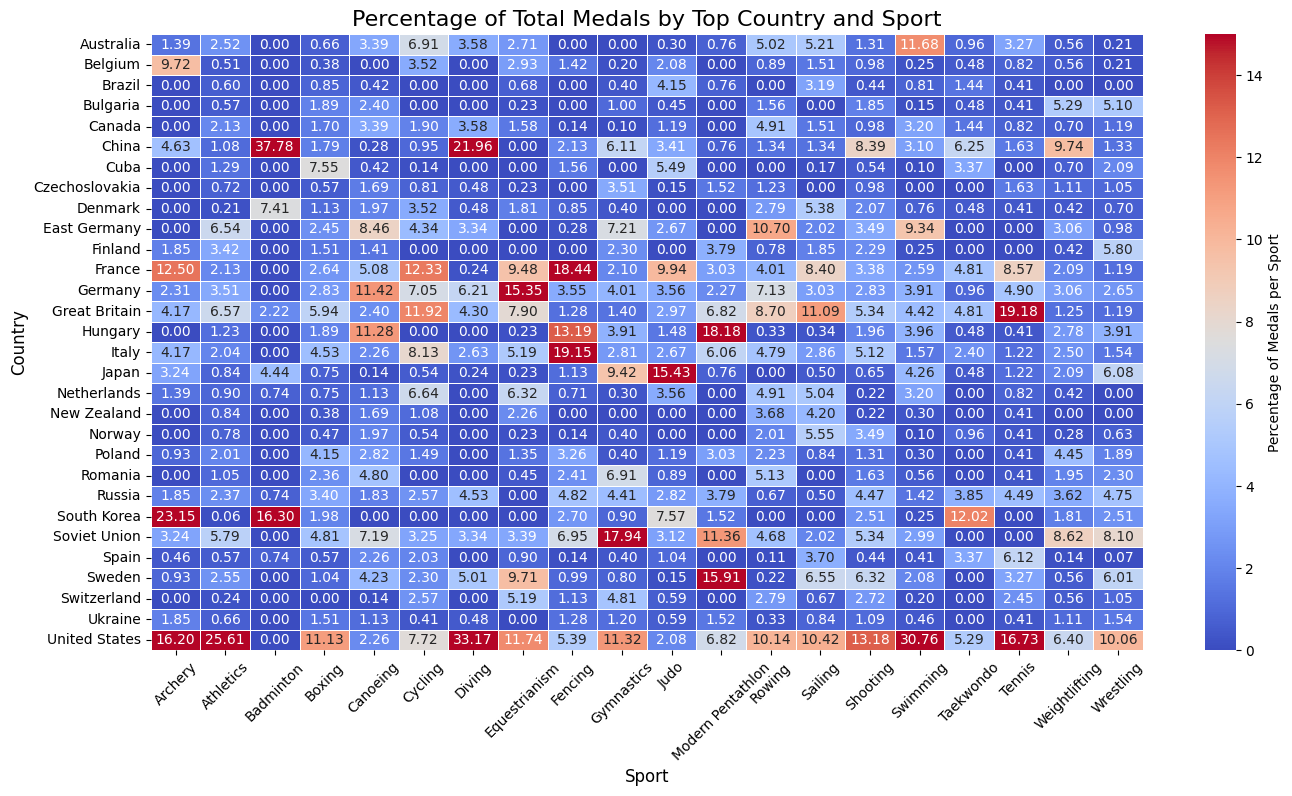

In [42]:
# Filter top countries and sports
top_countries = grouped_medals.groupby('Country Name')['Total_Medals'].sum().sort_values(ascending=False).head(31).index
top_sports = grouped_medals.groupby('Sport')['Total_Medals'].sum().sort_values(ascending=False).head(21).index
top_sports = top_sports[top_sports != "Art Competitions"]
top_countries = top_countries[top_countries != "West Germany"]

filtered_data = grouped_medals[grouped_medals['Country Name'].isin(top_countries) & grouped_medals['Sport'].isin(top_sports)]

# Pivot table for heatmap: Use the percentage column
heatmap_data = filtered_data.pivot_table(index='Country Name', columns='Sport', values='Country_Sport_Percentage', aggfunc='sum').fillna(0)

plt.figure(figsize=(16, 8))
sns.heatmap(
    heatmap_data, 
    cmap='coolwarm', 
    annot=True, 
    fmt='.2f', 
    linewidths=0.5, 
    cbar_kws={'label': 'Percentage of Medals per Sport'},
    vmin=0,  
    vmax=15  
)
plt.title('Percentage of Total Medals by Top Country and Sport', fontsize=16)
plt.xlabel('Sport', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.xticks(rotation=45)
plt.show()



The numbers in the heatmap represent the number of medals won by a country in a specific sport over the total possible.

So we can for example make some considerations such as that:

- South Korea excels in Archery, Badminton and Taekwondo.
- Australia in Swimming.
- China: Diving, Badminton and Weightlifting.
- France and Italy in Fencing.
- Japan in Judo.
- Soviet Union in Gymnastics.
- USA in almost every sport, especially Athletics, Swimming and Diving.

---

# 3. Prediction of total medals

## 3.1 Linear Regression model

### 3.1.1 GDP_norm vs. medals_norm

In [43]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df_clean = df_reduced.dropna(subset=['gdp_norm', 'medals_norm'])

X = (df_clean['gdp_norm']) 
y = (df_clean['medals_norm']) 

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

model = sm.OLS(y_train, X_train).fit()

y_pred = model.predict(X_test)

p_value = model.pvalues['gdp_norm']
print(f"P-value for GDP: {p_value}")


if p_value < 0.05:
    print("Reject the null hypothesis: GDP per capita is significantly associated with medal counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between GDP per capita and medal counts.")

model.summary()

P-value for GDP: 2.4313781144833736e-174
Reject the null hypothesis: GDP per capita is significantly associated with medal counts.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            medals_norm   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     1486.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          2.43e-174
Time:                        12:34:20   Log-Likelihood:                -526.02
No. Observations:                 693   AIC:                             1056.
Df Residuals:                     691   BIC:                             1065.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0503      0.020     -2.558      0.011      -0.089      -0.012
gdp_norm       0.7754      0.020     38.546      0.000       0.736       0.815
==============================================================================
Omnibus:                      448.440   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6884.045
Skew:                           2.655   Prob(JB):                         0.00
Kurtosis:                      17.499   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

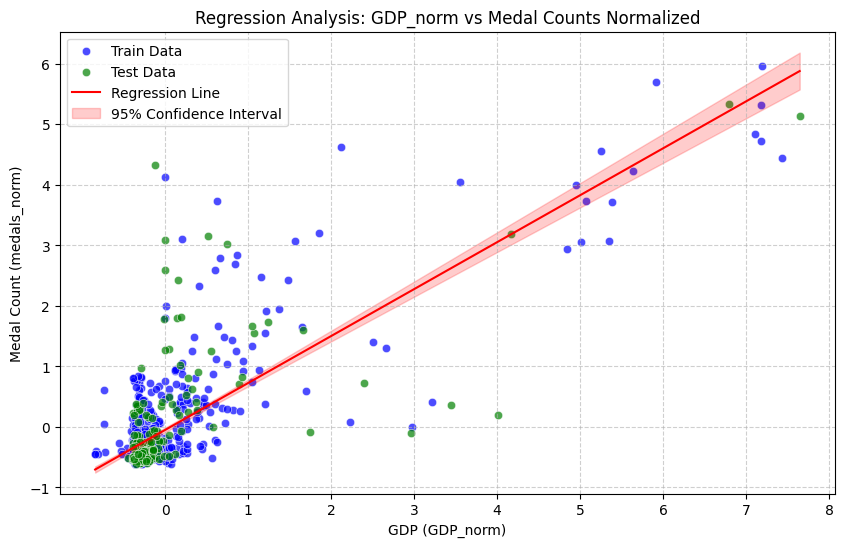

In [44]:
predictions = model.get_prediction(X)
conf_int = predictions.conf_int(alpha=0.05)  
mean_prediction = predictions.predicted_mean

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_train['gdp_norm'], y=y_train, label="Train Data", color="blue", alpha=0.7)

sns.scatterplot(x=X_test['gdp_norm'], y=y_test, label="Test Data", color="green", alpha=0.7)

sorted_indices = np.argsort(X['gdp_norm'].values) 
sorted_x = X['gdp_norm'].values[sorted_indices]
sorted_mean = mean_prediction[sorted_indices]
sorted_conf_low = conf_int[:, 0][sorted_indices]
sorted_conf_high = conf_int[:, 1][sorted_indices]

# Plot the regression line
plt.plot(sorted_x, sorted_mean, color='red', label="Regression Line")

# Plot the confidence interval band
plt.fill_between(sorted_x, sorted_conf_low, sorted_conf_high, color='red', alpha=0.2, label="95% Confidence Interval")

# Add labels, title, and legend
plt.title("Regression Analysis: GDP_norm vs Medal Counts Normalized")
plt.xlabel("GDP (GDP_norm)")
plt.ylabel("Medal Count (medals_norm)")
plt.legend()

plt.xticks(np.arange(0, 9, 1))  
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 3.1.2 GDP vs. total_medals

In [45]:
df_clean = df_reduced.dropna(subset=['GDP', 'total_medals'])
df_clean['log_gdp'] = np.log(df_reduced['GDP'])

X = (df_clean['log_gdp'])  
y = (df_clean['total_medals'])

X = sm.add_constant(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)


# Extracting and displaying the p-value for the independent variable
p_value = model.pvalues['log_gdp']
print(f"P-value for GDP: {p_value}")



if p_value < 0.05:
    print("Reject the null hypothesis: GDP per capita is significantly associated with medal counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between GDP per capita and medal counts.")

model.summary()


P-value for GDP: 4.197491933089766e-58
Reject the null hypothesis: GDP per capita is significantly associated with medal counts.


C:\Users\ricca\AppData\Local\Temp\ipykernel_20188\2672082376.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_gdp'] = np.log(df_reduced['GDP'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_medals   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     313.3
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           4.20e-58
Time:                        12:34:20   Log-Likelihood:                -2893.7
No. Observations:                 693   AIC:                             5791.
Df Residuals:                     691   BIC:                             5801.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -118.4642      7.360    -16.096      0.000    -132.915    -104.014
log_gdp        5.1652      0.292     17.702      0.000       4.592       5.738
==============================================================================
Omnibus:                      468.686   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6911.712
Skew:                           2.848   Prob(JB):                         0.00
Kurtosis:                      17.385   Cond. No.                         310.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

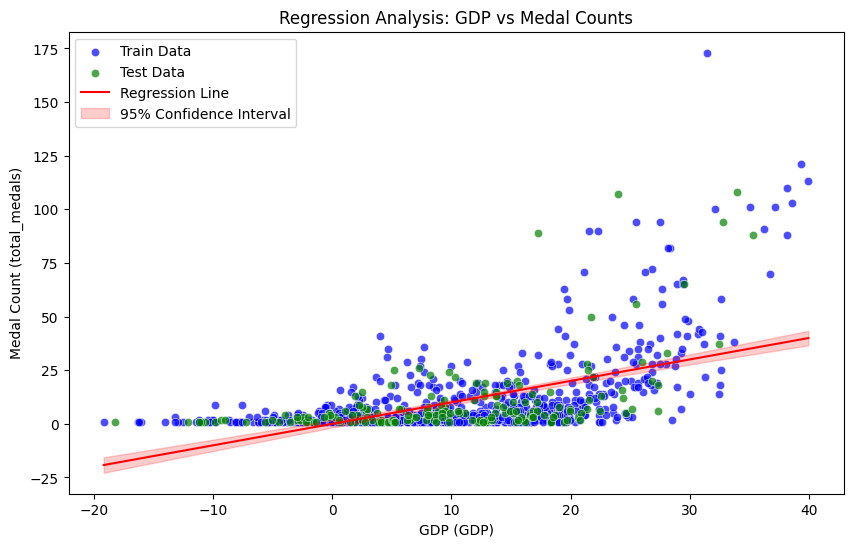

In [46]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=model.predict(X_train), y=y_train, label="Train Data", color="blue", alpha=0.7)

sns.scatterplot(x=model.predict(X_test), y=y_test, label="Test Data", color="green", alpha=0.7)

predictions = model.get_prediction(X_train)
confidence_intervals = predictions.conf_int(alpha=0.05)  # 95% confidence level
mean_prediction = predictions.predicted_mean

# Sort predictions for plotting
sorted_indices = mean_prediction.argsort()
sorted_mean = mean_prediction[sorted_indices]
sorted_conf_low = confidence_intervals[:, 0][sorted_indices]
sorted_conf_high = confidence_intervals[:, 1][sorted_indices]

# Plot the regression line
plt.plot(sorted_mean, sorted_mean, color='red', label="Regression Line")

# Plot the confidence interval band
plt.fill_between(sorted_mean, sorted_conf_low, sorted_conf_high, color='red', alpha=0.2, label="95% Confidence Interval")

# Add labels, title, and legend
plt.title("Regression Analysis: GDP vs Medal Counts")
plt.xlabel("GDP (GDP)")
plt.ylabel("Medal Count (total_medals)")
plt.legend()

plt.show()


### 3.1.3 Total_Athletes vs. total_medals

In [47]:
df_clean = df_reduced.dropna(subset=['Total_Athletes', 'total_medals'])

X = (df_clean['Total_Athletes'])  
y = (df_clean['total_medals'])  

X = sm.add_constant(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)

p_value = model.pvalues['Total_Athletes']
print(f"P-value for GDP: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: GDP is significantly associated with medal counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between GDP per capita and medal counts.")

model.summary()


P-value for GDP: 2.1710271658321285e-204
Reject the null hypothesis: GDP is significantly associated with medal counts.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_medals   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     1778.
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          2.17e-204
Time:                        12:34:21   Log-Likelihood:                -3051.4
No. Observations:                 792   AIC:                             6107.
Df Residuals:                     790   BIC:                             6116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.6283      0.570     -8.127      0.000      -5.746      -3.510
Total_Athletes     0.1428      0.003     42.161      0.000       0.136       0.149
==============================================================================
Omnibus:                      459.653   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6619.330
Skew:                           2.326   Prob(JB):                         0.00
Kurtosis:                      16.377   Cond. No.                         236.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

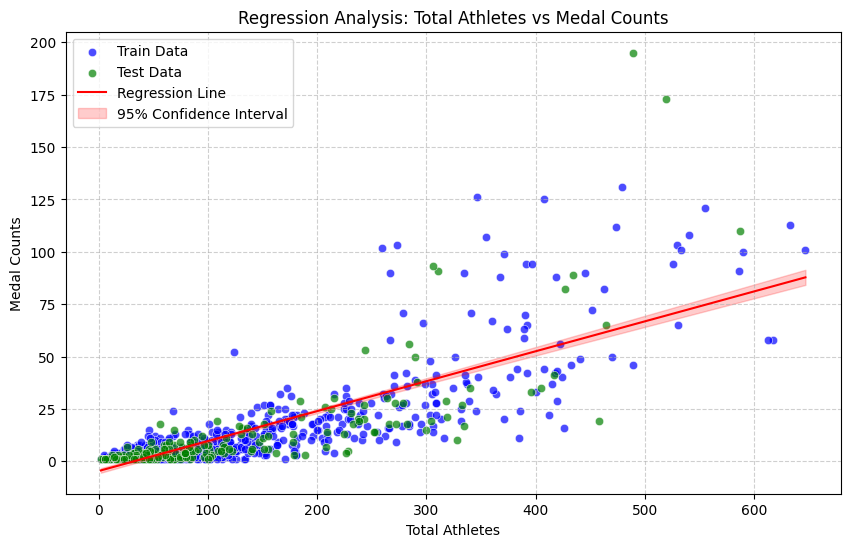

In [48]:
predictions = model.get_prediction(X)
conf_int = predictions.conf_int(alpha=0.05)  # 95% confidence level
mean_prediction = predictions.predicted_mean

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_train['Total_Athletes'], y=y_train, label="Train Data", color="blue", alpha=0.7)

sns.scatterplot(x=X_test['Total_Athletes'], y=y_test, label="Test Data", color="green", alpha=0.7)

sorted_indices = np.argsort(X['Total_Athletes'].values) 
sorted_x = X['Total_Athletes'].values[sorted_indices]
sorted_mean = mean_prediction[sorted_indices]
sorted_conf_low = conf_int[:, 0][sorted_indices]
sorted_conf_high = conf_int[:, 1][sorted_indices]

# Plot the regression line
plt.plot(sorted_x, sorted_mean, color='red', label="Regression Line")

# Plot the confidence interval band
plt.fill_between(sorted_x, sorted_conf_low, sorted_conf_high, color='red', alpha=0.2, label="95% Confidence Interval")

plt.title("Regression Analysis: Total Athletes vs Medal Counts")
plt.xlabel("Total Athletes")
plt.ylabel("Medal Counts")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 3.1.4 GDP_pc_norm vs. medals_norm

In [49]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df_clean = df_reduced.dropna(subset=['gdp_pc_norm', 'medals_norm'])

X = (df_clean['gdp_pc_norm'])  # Independent variable (normalized GDP per capita)
y = (df_clean['medals_norm'])  # Dependent variable (normalized medal count)

X = sm.add_constant(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)


p_value = model.pvalues['gdp_pc_norm']
print(f"P-value for GDP: {p_value}")



if p_value < 0.05:
    print("Reject the null hypothesis: GDP per capita is significantly associated with medal counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between GDP per capita and medal counts.")


model.summary()

P-value for GDP: 4.369041852858921e-16
Reject the null hypothesis: GDP per capita is significantly associated with medal counts.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            medals_norm   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     69.38
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           4.37e-16
Time:                        12:34:22   Log-Likelihood:                -918.91
No. Observations:                 693   AIC:                             1842.
Df Residuals:                     691   BIC:                             1851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0269      0.035     -0.776      0.438      -0.095       0.041
gdp_pc_norm     0.2864      0.034      8.329      0.000       0.219       0.354
==============================================================================
Omnibus:                      472.333   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4902.889
Skew:                           3.046   Prob(JB):                         0.00
Kurtosis:                      14.519   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

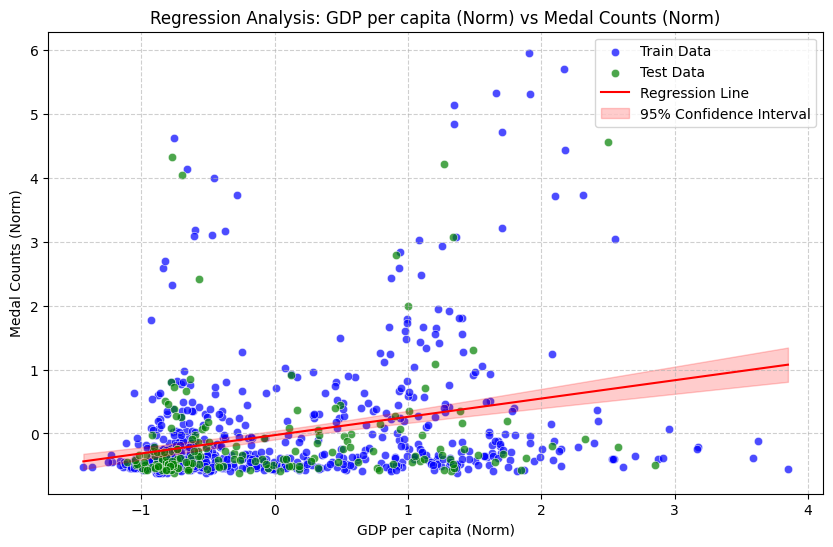

In [50]:
predictions = model.get_prediction(X)
conf_int = predictions.conf_int(alpha=0.05)  # 95% confidence level
mean_prediction = predictions.predicted_mean

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_train['gdp_pc_norm'], y=y_train, label="Train Data", color="blue", alpha=0.7)

sns.scatterplot(x=X_test['gdp_pc_norm'], y=y_test, label="Test Data", color="green", alpha=0.7)

sorted_indices = np.argsort(X['gdp_pc_norm'].values)  # Sort by gdp_norm
sorted_x = X['gdp_pc_norm'].values[sorted_indices]
sorted_mean = mean_prediction[sorted_indices]
sorted_conf_low = conf_int[:, 0][sorted_indices]
sorted_conf_high = conf_int[:, 1][sorted_indices]

# Plot the regression line
plt.plot(sorted_x, sorted_mean, color='red', label="Regression Line")

# Plot the confidence interval band
plt.fill_between(sorted_x, sorted_conf_low, sorted_conf_high, color='red', alpha=0.2, label="95% Confidence Interval")

# Add labels, title, and legend
plt.title("Regression Analysis: GDP per capita (Norm) vs Medal Counts (Norm)")
plt.xlabel("GDP per capita (Norm)")
plt.ylabel("Medal Counts (Norm)")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 3.1.5 HDI vs. total_medals

In [51]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df_clean = df_reduced.dropna(subset=['HDI', 'total_medals'])

X = (df_clean['HDI'])  # Independent variable (normalized HDI)
y = (df_clean['total_medals'])  # Dependent variable (normalized medal count)

X = sm.add_constant(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)

p_value = model.pvalues['HDI']
print(f"P-value for GDP: {p_value}")


if p_value < 0.05:
    print("Reject the null hypothesis: HDI is significantly associated with medal counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between HDI and medal counts.")


model.summary()


P-value for GDP: 2.442230904056161e-09
Reject the null hypothesis: HDI is significantly associated with medal counts.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_medals   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     36.98
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           2.44e-09
Time:                        12:34:23   Log-Likelihood:                -2100.0
No. Observations:                 480   AIC:                             4204.
Df Residuals:                     478   BIC:                             4212.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.3544      5.018     -3.459      0.001     -27.214      -7.495
HDI           39.5911      6.510      6.081      0.000      26.799      52.383
==============================================================================
Omnibus:                      305.357   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2249.873
Skew:                           2.829   Prob(JB):                         0.00
Kurtosis:                      11.972   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

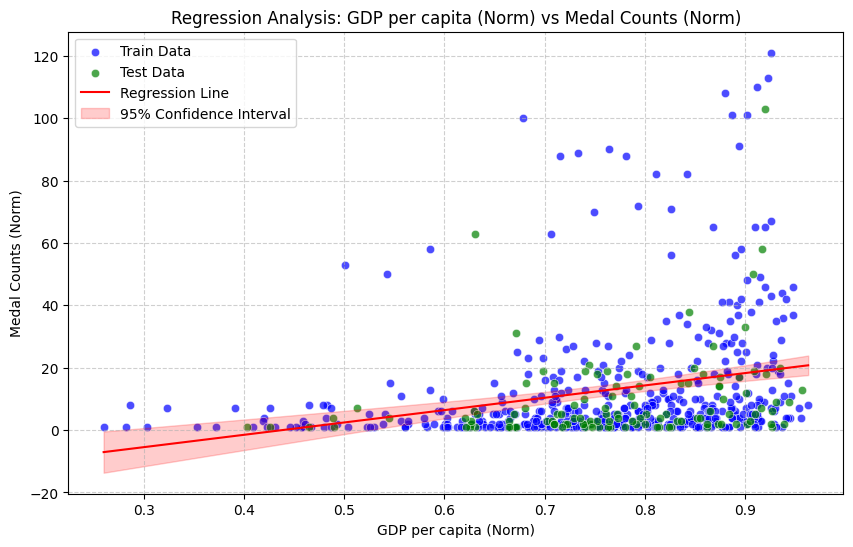

In [52]:
predictions = model.get_prediction(X)
conf_int = predictions.conf_int(alpha=0.05)  # 95% confidence level
mean_prediction = predictions.predicted_mean

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_train['HDI'], y=y_train, label="Train Data", color="blue", alpha=0.7)

sns.scatterplot(x=X_test['HDI'], y=y_test, label="Test Data", color="green", alpha=0.7)

sorted_indices = np.argsort(X['HDI'].values)  # Sort by gdp_norm
sorted_x = X['HDI'].values[sorted_indices]
sorted_mean = mean_prediction[sorted_indices]
sorted_conf_low = conf_int[:, 0][sorted_indices]
sorted_conf_high = conf_int[:, 1][sorted_indices]

plt.plot(sorted_x, sorted_mean, color='red', label="Regression Line")

# Plot the confidence interval band
plt.fill_between(sorted_x, sorted_conf_low, sorted_conf_high, color='red', alpha=0.2, label="95% Confidence Interval")

# Add labels, title, and legend
plt.title("Regression Analysis: GDP per capita (Norm) vs Medal Counts (Norm)")
plt.xlabel("GDP per capita (Norm)")
plt.ylabel("Medal Counts (Norm)")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 3.1.6 Population_perc vs. medals_norm

In [53]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df_clean = df_reduced.dropna(subset=['Population_perc', 'medals_norm'])

X = (df_clean['Population_perc'])  # Independent variable (normalized GDP per capita)
y = (df_clean['medals_norm'])  # Dependent variable (normalized medal count)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model

# Extracting and displaying the p-value for the independent variable
p_value = model.pvalues['Population_perc']
print(f"P-value for GDP: {p_value}")


if p_value < 0.05:
    print("Reject the null hypothesis: HDI is significantly associated with medal counts.")
else:
    print("Fail to reject the null hypothesis: No significant association between HDI and medal counts.")


model.summary()


P-value for GDP: 2.76536301862528e-15
Reject the null hypothesis: HDI is significantly associated with medal counts.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            medals_norm   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     65.15
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           2.77e-15
Time:                        12:34:23   Log-Likelihood:                -987.14
No. Observations:                 749   AIC:                             1978.
Df Residuals:                     747   BIC:                             1988.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1274      0.035     -3.612      0.000      -0.197      -0.058
Population_perc     0.0532      0.007      8.072      0.000       0.040       0.066
==============================================================================
Omnibus:                      491.251   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5255.469
Skew:                           2.887   Prob(JB):                         0.00
Kurtosis:                      14.621   Cond. No.                         5.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

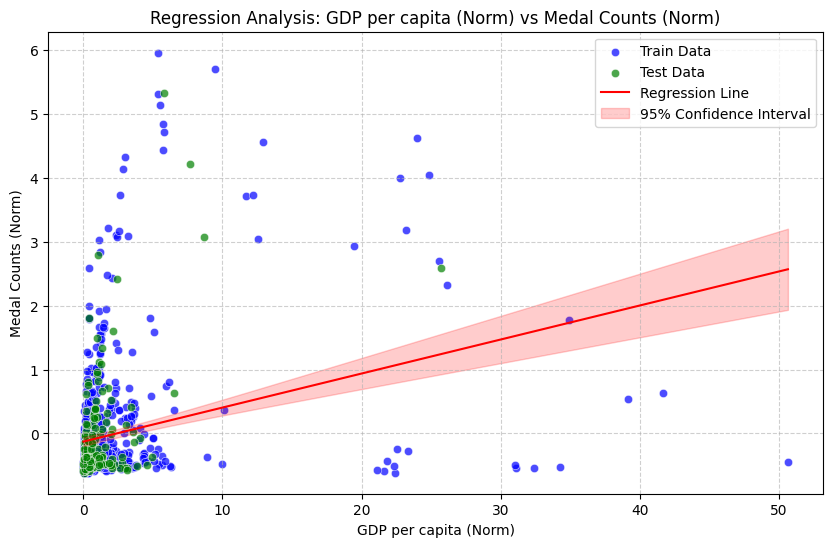

In [54]:
predictions = model.get_prediction(X)
conf_int = predictions.conf_int(alpha=0.05)  # 95% confidence level
mean_prediction = predictions.predicted_mean

plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_train['Population_perc'], y=y_train, label="Train Data", color="blue", alpha=0.7)

# Scatter plot for actual data (test set)
sns.scatterplot(x=X_test['Population_perc'], y=y_test, label="Test Data", color="green", alpha=0.7)

sorted_indices = np.argsort(X['Population_perc'].values)  
sorted_x = X['Population_perc'].values[sorted_indices]
sorted_mean = mean_prediction[sorted_indices]
sorted_conf_low = conf_int[:, 0][sorted_indices]
sorted_conf_high = conf_int[:, 1][sorted_indices]

# Plot the regression line
plt.plot(sorted_x, sorted_mean, color='red', label="Regression Line")

# Plot the confidence interval band
plt.fill_between(sorted_x, sorted_conf_low, sorted_conf_high, color='red', alpha=0.2, label="95% Confidence Interval")

# Add labels, title, and legend
plt.title("Regression Analysis: GDP per capita (Norm) vs Medal Counts (Norm)")
plt.xlabel("GDP per capita (Norm)")
plt.ylabel("Medal Counts (Norm)")
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## 3.2 Multi-Linear Regression model

In [55]:
df_clean = df_reduced.dropna(subset=['medals_norm', 'Country_Host', 'gdp_norm', 'Total_Athletes', 'Population_perc', 'HDI'])

# Define independent and dependent variables
X = (df_clean[['Country_Host', 'gdp_norm', 'Total_Athletes', 'Population_perc', 'HDI']])
y = (df_clean['medals_norm'])  # Dependent variable (normalized medal count)

# Add a constant for the intercept in the statsmodels regression
X = sm.add_constant(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            medals_norm   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     554.3
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          1.53e-193
Time:                        12:34:24   Log-Likelihood:                -208.18
No. Observations:                 472   AIC:                             428.4
Df Residuals:                     466   BIC:                             453.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2668      0.119     -2.247      0.025      -0.500      -0.033
Country_Host       -0.4914      0.170     -2.893      0.004      -0.825      -0.158
gdp_norm            0.3341      0.025     13.233      0.000       0.284       0.384
Total_Athletes      0.0051      0.000     23.800      0.000       0.005       0.006
Population_perc     0.0209      0.005      4.008      0.000       0.011       0.031
HDI                -0.4914      0.161     -3.060      0.002      -0.807      -0.176
==============================================================================
Omnibus:                      103.559   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              987.071
Skew:                           0.635   Prob(JB):                    4.57e-215
Kurtosis:                       9.970   Cond. No.                     2.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
# what is the error associated with this prediction?
y_predicted = model.predict(X)
np.sqrt(metrics.mean_squared_error(y, y_predicted))

0.41255983771909477

# 4. Predictions

## 4.1 Predictions for medals_norm

Test MSE: 0.2852
Test R²: 0.7620


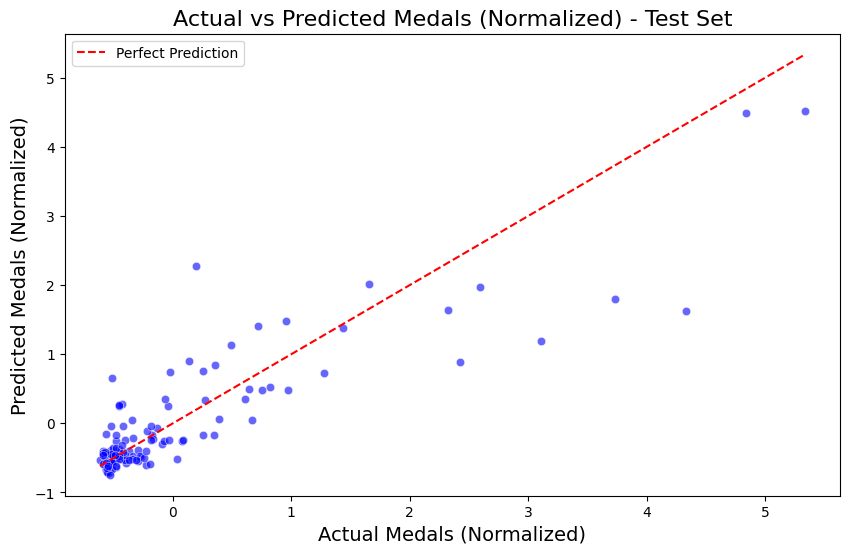

In [57]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_results['Actual'], y=test_results['Predicted'], alpha=0.6, color="blue")

plt.plot(
    [test_results['Actual'].min(), test_results['Actual'].max()],
    [test_results['Actual'].min(), test_results['Actual'].max()],
    color='red', linestyle='--', label='Perfect Prediction'
)

plt.title('Actual vs Predicted Medals (Normalized) - Test Set', fontsize=16)
plt.xlabel('Actual Medals (Normalized)', fontsize=14)
plt.ylabel('Predicted Medals (Normalized)', fontsize=14)
plt.legend()
plt.show()



## 4.2 Predictions for total_medals

In [58]:
df_clean = df_reduced.dropna(subset=['total_medals', 'Country_Host', 'gdp_norm', 'Total_Athletes', 'Population_perc', 'HDI'])

X = (df_clean[['Country_Host', 'gdp_norm', 'Total_Athletes', 'Population_perc', 'HDI']])
y = (df_clean['total_medals']) 

X = sm.add_constant(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_medals   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     434.9
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          6.07e-173
Time:                        12:34:25   Log-Likelihood:                -1618.3
No. Observations:                 472   AIC:                             3249.
Df Residuals:                     466   BIC:                             3274.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.1014      2.293      3.533      0.000       3.595      12.608
Country_Host      -14.3157      3.176     -4.508      0.000     -20.556      -8.075
gdp_norm            5.5521      0.535     10.384      0.000       4.501       6.603
Total_Athletes      0.1085      0.004     25.334      0.000       0.100       0.117
Population_perc     0.1233      0.112      1.097      0.273      -0.097       0.344
HDI               -12.2617      3.082     -3.979      0.000     -18.318      -6.205
==============================================================================
Omnibus:                      148.070   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1168.238
Skew:                           1.127   Prob(JB):                    2.09e-254
Kurtosis:                      10.371   Cond. No.                     1.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Test MSE: 77.4421
Test R²: 0.8560


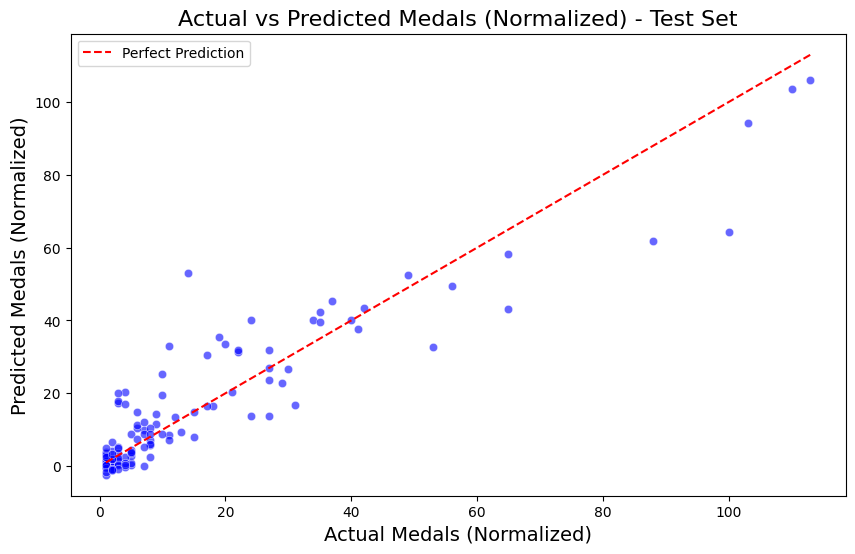

In [59]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_results['Actual'], y=test_results['Predicted'], alpha=0.6, color="blue")

plt.plot(
    [test_results['Actual'].min(), test_results['Actual'].max()],
    [test_results['Actual'].min(), test_results['Actual'].max()],
    color='red', linestyle='--', label='Perfect Prediction'
)

plt.title('Actual vs Predicted Medals (Normalized) - Test Set', fontsize=16)
plt.xlabel('Actual Medals (Normalized)', fontsize=14)
plt.ylabel('Predicted Medals (Normalized)', fontsize=14)
plt.legend()
plt.show()


---

# 5 PCA

From the correlation matrix and from the condition number we can observe that performing linear regression to all the variables of the DataFrame may lead to multicollinearity problems.

In fact the condition number is extremely high. This suggests the presence of strong multicollinearity, signifying that features may represent similar information and are correlated with each other.

To solve this problem we can explore an alternative regression model by incorporating Principal Component Analysis (PCA) before applying OLS and than understand the results.

[0.42776157 0.67400029 0.8542713  0.9469189  1.        ]


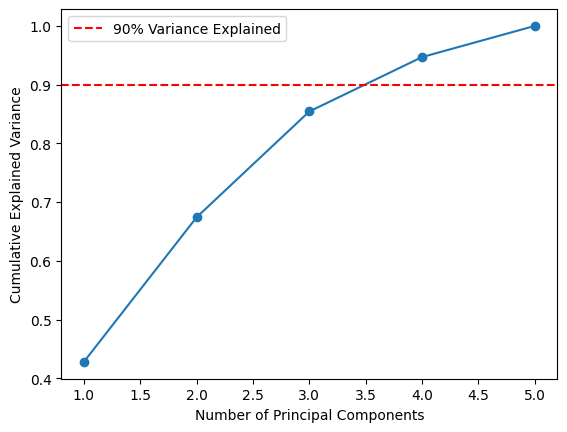

In [60]:

X_scaled = StandardScaler().fit_transform(df_clean[['gdp_norm', 'Total_Athletes', 'Population_perc', 'Country_Host', 'HDI']])

pca = PCA()
pca.fit(X_scaled)  

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(explained_variance)  # View cumulative variance

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label="90% Variance Explained")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()


In [61]:
# Apply PCA
pca = PCA(n_components=3)  # Number of principal components to keep
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

df_pca['medals_norm'] = df_clean['medals_norm'].values  # Ensuring proper alignment

X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('medals_norm', axis=1), df_pca['medals_norm'], test_size=0.2, random_state=2)

X_train = sm.add_constant(X_train)  # Add a constant for the intercept in the regression model
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)


model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            medals_norm   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     517.9
Date:                Mon, 16 Dec 2024   Prob (F-statistic):          3.00e-148
Time:                        12:34:26   Log-Likelihood:                -336.10
No. Observations:                 472   AIC:                             680.2
Df Residuals:                     468   BIC:                             696.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0394      0.023      1.726      0.085      -0.005       0.084
PC1            0.5977      0.016     36.843      0.000       0.566       0.630
PC2            0.0596      0.021      2.866      0.004       0.019       0.101
PC3           -0.1702      0.025     -6.802      0.000      -0.219      -0.121
==============================================================================
Omnibus:                      177.637   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1831.310
Skew:                           1.322   Prob(JB):                         0.00
Kurtosis:                      12.281   Cond. No.                         1.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Test MSE: 0.2421
Test R²: 0.7346


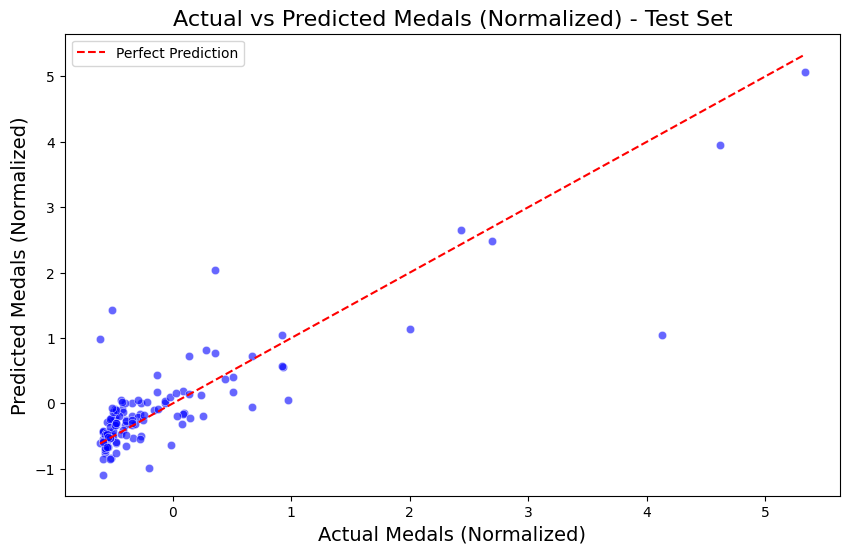

In [62]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_results['Actual'], y=test_results['Predicted'], alpha=0.6, color="blue")

plt.plot(
    [test_results['Actual'].min(), test_results['Actual'].max()],
    [test_results['Actual'].min(), test_results['Actual'].max()],
    color='red', linestyle='--', label='Perfect Prediction'
)

plt.title('Actual vs Predicted Medals (Normalized) - Test Set', fontsize=16)
plt.xlabel('Actual Medals (Normalized)', fontsize=14)
plt.ylabel('Predicted Medals (Normalized)', fontsize=14)
plt.legend()
plt.show()


# 6. Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split

X = df_clean[['gdp_norm', 'Total_Athletes', 'Population_perc', 'Country_Host', 'HDI']]
y = df_clean['medals_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')

# Feature importance
print("Feature Importance:", model.feature_importances_)


MSE: 0.08148775250187264
R²: 0.9106831685583797
Feature Importance: [0.10646462 0.73982601 0.10890011 0.00678894 0.03802033]


In [64]:
# Predict on training data
y_train_pred = model.predict(X_train)

# Evaluate the model on training data
train_r2 = r2_score(y_train, y_train_pred)

print(f'Train R²: {train_r2}')


Train R²: 0.9785618521076667


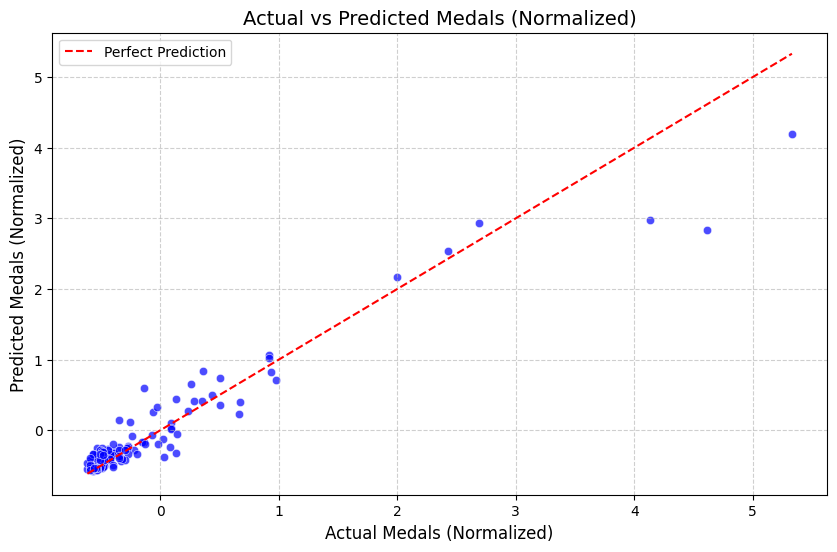

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.7)

line = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(line, line, color="red", linestyle="--", label="Perfect Prediction")

plt.title("Actual vs Predicted Medals (Normalized)", fontsize=14)
plt.xlabel("Actual Medals (Normalized)", fontsize=12)
plt.ylabel("Predicted Medals (Normalized)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


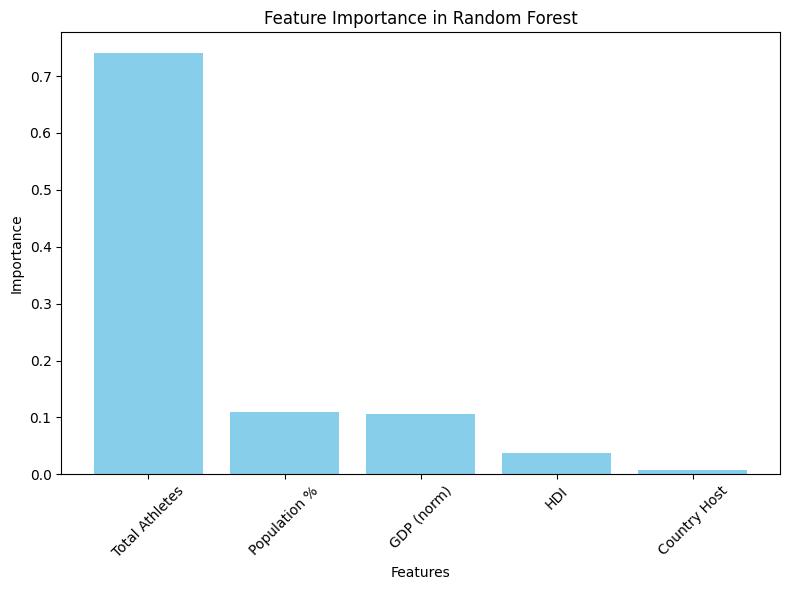

In [66]:
import matplotlib.pyplot as plt
import numpy as np

features = ['GDP (norm)', 'Total Athletes', 'Population %', 'Country Host', 'HDI']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center", color="skyblue")
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig("random_forest_feature_importance.png")  # Save for the slide
plt.show()


# 6. Clustering for a better regression

c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[[-0.23885316 -0.30755625]
 [ 6.21106001  4.5603888 ]
 [ 0.88976486  1.75552104]]


C:\Users\ricca\AppData\Local\Temp\ipykernel_21740\3275617586.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Cluster'] = kmeans.fit_predict(df_scaled)


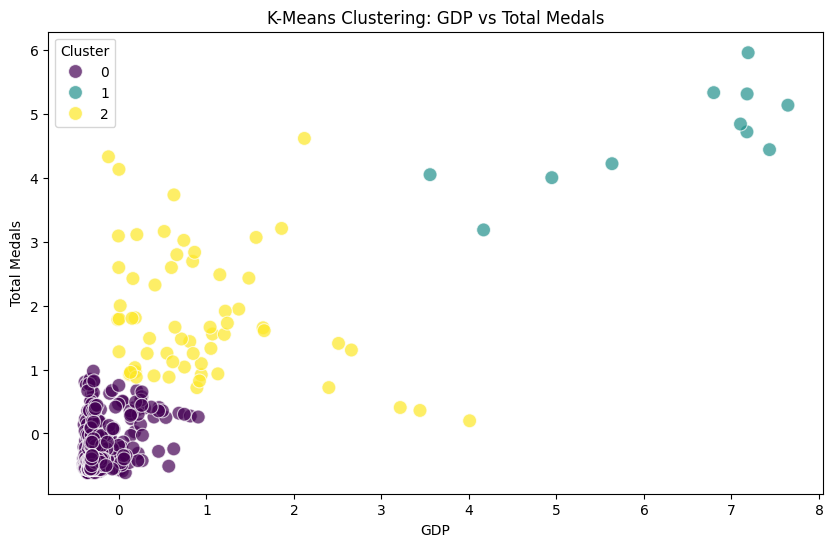

In [402]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


features = ['gdp_norm', 'medals_norm']  
df_clustering = df_clean[features]

# Step 1: Standardize the data (important for K-Means)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Step 2: Apply the K-Means algorithm
kmeans = KMeans(n_clusters=3, random_state=42) 
df_clean['Cluster'] = kmeans.fit_predict(df_scaled)

# Step 3: Analyze the clusters
print(kmeans.cluster_centers_)

# Step 4: Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clean['gdp_norm'], y=df_clean['medals_norm'], hue=df_clean['Cluster'], palette='viridis', s=100, alpha=0.7)

plt.title('K-Means Clustering: GDP vs Total Medals')
plt.xlabel('GDP')
plt.ylabel('Total Medals')
plt.legend(title='Cluster')
plt.show()


c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

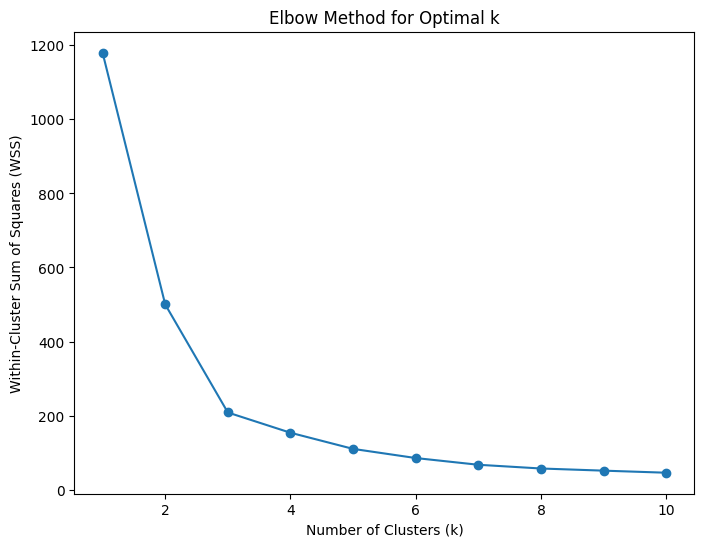

In [403]:
# Elbow Method to find the optimal number of clusters
wss = []
for k in range(1, 11):  # Trying k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wss.append(kmeans.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.show()
